## **Install and Import**

In [ ]:
!pip install segmentation-models-pytorch albumentations -q


In [ ]:
import torch, torchvision
import numpy as np, matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

## **Load Oxford-IIIT Pet Dataset**

In [ ]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

root = "data/pets"
train_dataset = OxfordIIITPet(root, split="trainval", target_types="segmentation", download=True)

100%|██████████| 792M/792M [00:35<00:00, 22.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.5MB/s]


## **Custom Dataset Class + Transforms**

In [ ]:
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
])

class PetSegDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset, self.transform = dataset, transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, i):
        img, mask = self.dataset[i]
        img = np.array(img)
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)  # convert to binary
        if self.transform:
            t = self.transform(image=img, mask=mask)
            img, mask = t['image'], t['mask']
        return img.float(), mask.unsqueeze(0).float()

## **Dataloaders**

In [ ]:
ds = PetSegDataset(train_dataset, transform)
train_size = int(0.8 * len(ds))
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, len(ds) - train_size])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2)


## **Define U-Net Model**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

loss_fn = smp.losses.DiceLoss(mode='binary')
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


## **Training Loop**

In [ ]:
def train_epoch(model, loader):
    model.train(); total = 0
    for x, y in loader:
        x, y = x.to(device), y.float().to(device)
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
        total += loss.item()
    return total / len(loader)

def eval_dice(model, loader):
    model.eval(); dice = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.float().to(device)
            p = (model(x) > 0.5).float()
            inter = (p * y).sum()
            dice += 2 * inter / (p.sum() + y.sum() + 1e-8)
    return dice / len(loader)

for epoch in range(2):  # 2 epochs = fast demo
    loss = train_epoch(model, train_loader)
    dice = eval_dice(model, val_loader)
    print(f"Epoch {epoch+1}: loss={loss:.4f} dice={dice:.4f}")


Epoch 1: loss=0.1562 dice=1.0000
Epoch 2: loss=0.1554 dice=1.0000


## **Visualize Predictions**

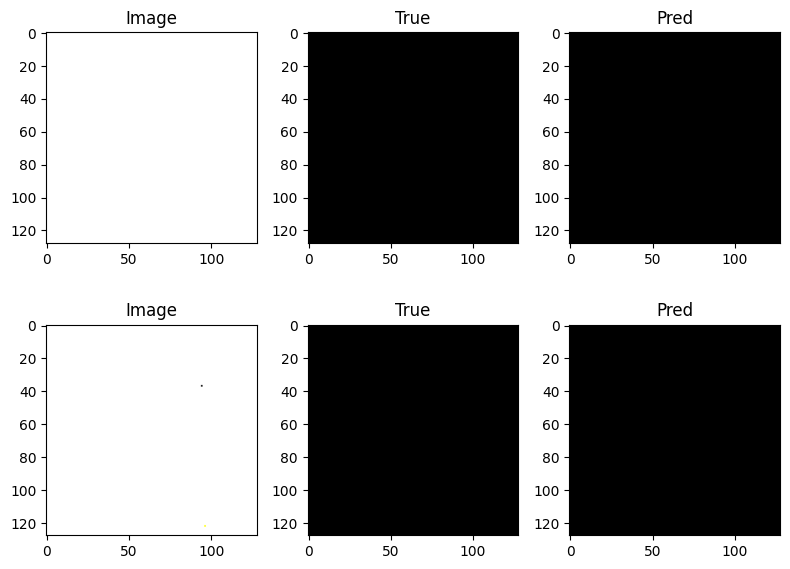

In [ ]:
x, y = next(iter(val_loader))
x = x.to(device)
with torch.no_grad(): p = (model(x) > 0.5).float().cpu()

plt.figure(figsize=(8, 6))
for i in range(2):
    plt.subplot(2, 3, 3*i+1); plt.imshow(x[i].permute(1,2,0).cpu()); plt.title('Image')
    plt.subplot(2, 3, 3*i+2); plt.imshow(y[i].squeeze(), cmap='gray'); plt.title('True')
    plt.subplot(2, 3, 3*i+3); plt.imshow(p[i].squeeze(), cmap='gray'); plt.title('Pred')
plt.tight_layout(); plt.show()
